In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# import train_rhorho, train_a1rho, train_a1a1

## Raw Dataset Visualization

In [11]:
rhorho_raw_H = np.load("HiggsCP_data/rhorho/rhorho_raw.data.npy")
rhorho_raw_Z = np.load("HiggsCP_data/rhorho/rhorhoZ_raw.data.npy")

In [12]:
df_rhorho_raw_H = pd.DataFrame(rhorho_raw_H)
df_rhorho_raw_Z = pd.DataFrame(rhorho_raw_Z)

In [13]:
for i in range(4,30,5):
    df_rhorho_H = df_rhorho_raw_H
    df_rhorho_Z = df_rhorho_raw_Z
    df_rhorho_H.drop(columns=i, inplace=True)
    df_rhorho_Z.drop(columns=i, inplace=True)

In [14]:
particle_name = ['n', 'pi-', 'pi0_1', 'an', 'pi+', 'pi0_2']
df_rhorho_H.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
df_rhorho_Z.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])

### Input feature Distributions

Text(0, 0.5, 'Counts for pi+')

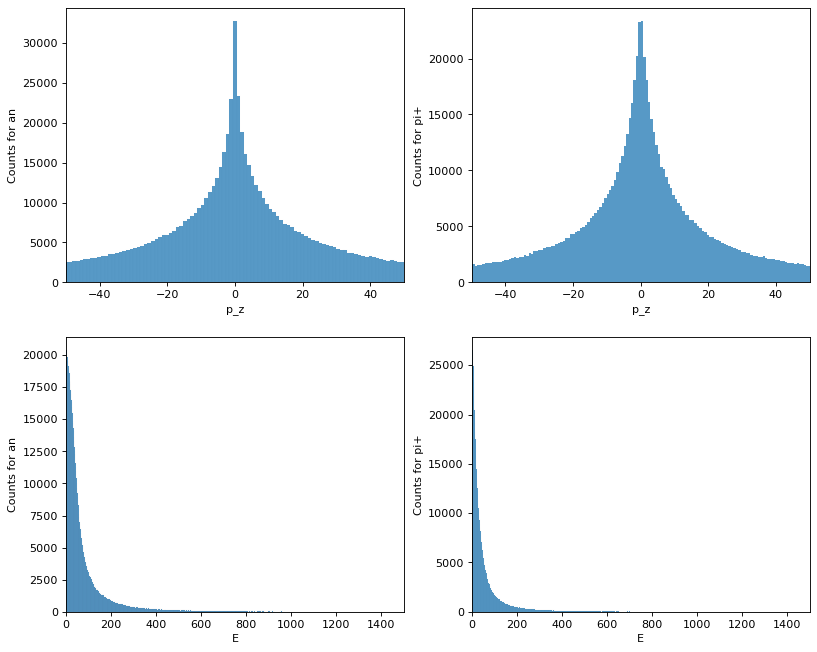

In [15]:
fig,ax=plt.subplots(2,2,figsize=(12,10),dpi = 80)
# for idx,name in enumerate(particle_name):   
# for hor_posi in range(3):
#     sns.scatterplot(data=df_rhorho_H[('pi-')], x=df_rhorho_H[('pi-')].columns[hor_posi],ax = ax[hor_posi])
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df_rhorho_H[('an')], x='p_z', ax = ax[0,0])
sns.histplot(data=df_rhorho_H[('an')], x='E', ax = ax[1,0])
sns.histplot(data=df_rhorho_H[('pi+')], x='p_z', ax = ax[0,1])
sns.histplot(data=df_rhorho_H[('pi+')], x='E', ax = ax[1,1])
ax[0,0].set_xlim((-50, 50))
ax[1,0].set_xlim((0, 1500))
ax[0,1].set_xlim((-50, 50))
ax[1,1].set_xlim((0, 1500))
ax[0,0].set_ylabel('Counts for an',fontsize=10)
ax[0,0].set_ylabel('Counts for an',fontsize=10)
ax[0,0].set_ylabel('Counts for an',fontsize=10)
ax[1,0].set_ylabel('Counts for an',fontsize=10)
ax[0,1].set_ylabel('Counts for pi+',fontsize=10)
ax[1,1].set_ylabel('Counts for pi+',fontsize=10)

### Correlations

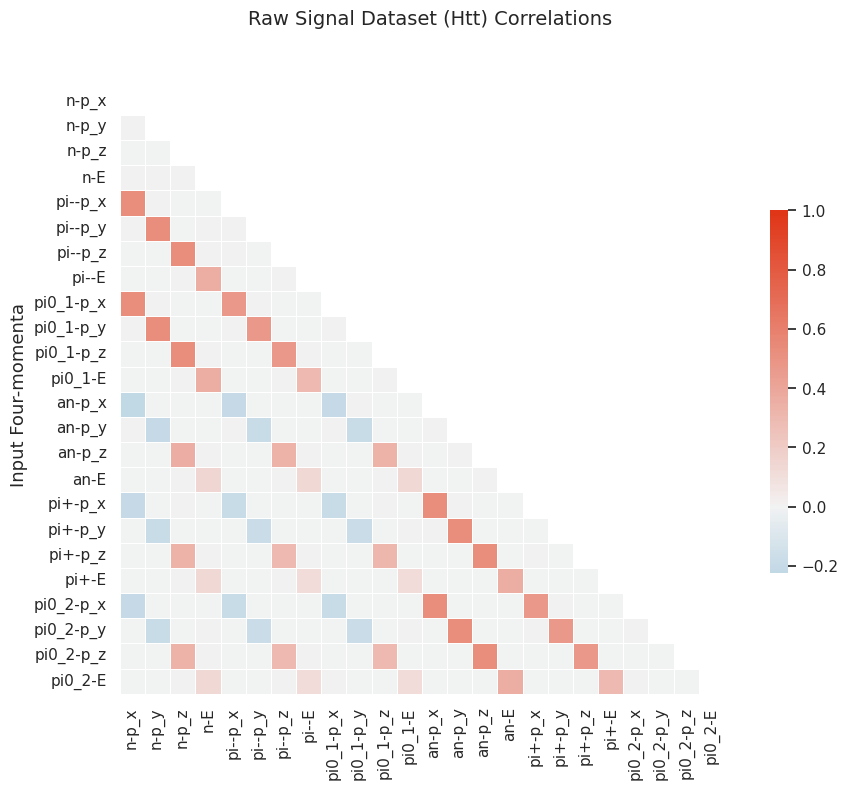

In [16]:
from string import ascii_letters

def corre_plot(df, figtitle='', ax_lable = ''):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8), dpi=100)
    f.suptitle(figtitle, fontsize=14)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 15, as_cmap=True, s=95, l=50)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .6})
    ax.set_ylabel(ax_lable,fontsize=13)
    ax.set_xlabel('')
    
    return

corre_plot(df_rhorho_H, figtitle='Raw Signal Dataset (Htt) Correlations', ax_lable= 'Input Four-momenta ')

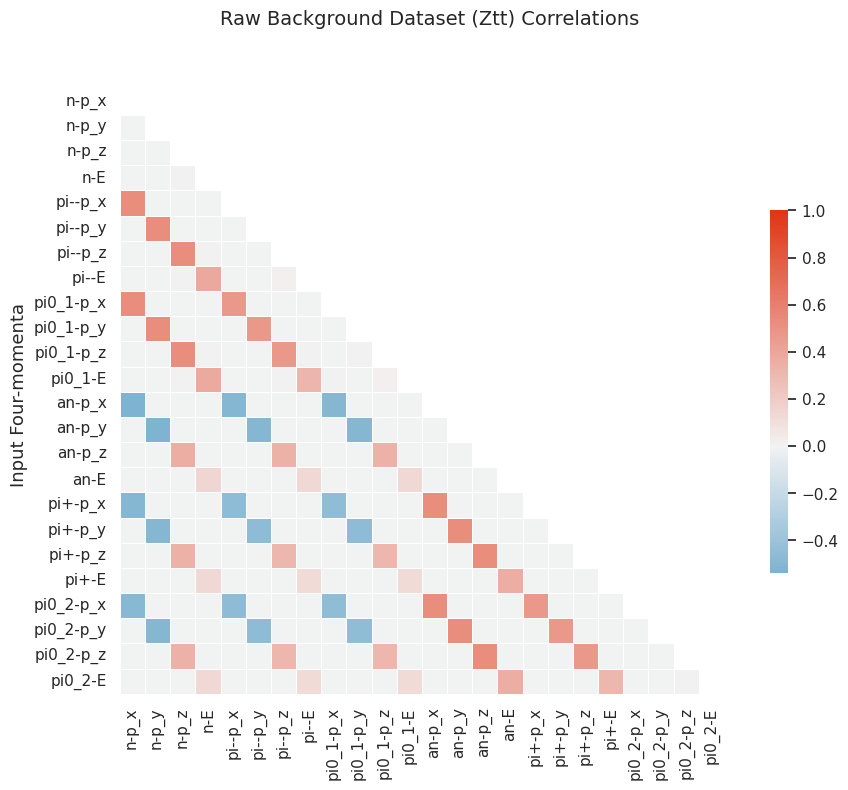

In [17]:
corre_plot(df_rhorho_Z, figtitle='Raw Background Dataset (Ztt) Correlations', ax_lable= 'Input Four-momenta ')

## Preprocessed Dataset Visualization

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
import sys
import pandas as pd
import argparse
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import train_rhorho, train_a1rho, train_a1a1

types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

decaymodes = ['rhorho', 'a1rho', 'a1a1']
decaymode = decaymodes[0]  ###### Change this to corresponding decaymode ############

parser.add_argument("-i", "--input", dest="IN", default='HiggsCP_data/'+ decaymode)
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_'+ decaymode)
args, unknown = parser.parse_known_args()

2021-11-25 19:58:20.304654: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term


In [20]:
points_S=pickle.load(open(args.IN+'/events_wo_background.pk','rb'))

In [21]:
df_rhorho_H_process = pd.DataFrame(points_S.train.x)
df_rhorho_H_process.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
df_rhorho_H_process

n                                     pi-                      \
             p_x       p_y       p_z         E       p_x       p_y       p_z   
0       0.360633 -0.144806  1.067600 -1.068035 -0.682809  1.480846 -1.649162   
1      -1.832799 -0.416735 -0.548903  0.549042 -1.532419 -0.683191  0.538462   
2       0.616122 -0.722304  0.734036 -0.734099 -1.166338  0.161584 -1.305956   
3       1.777235 -0.783875 -0.680616  0.680770 -1.105884 -1.056418  0.183487   
4      -2.373349  0.749877 -1.567539  1.567968  1.110217 -0.775169  0.673204   
...          ...       ...       ...       ...       ...       ...       ...   
799995 -0.926069  0.399152  0.620867 -0.621039  0.324470 -0.765064  0.696984   
799996  1.275280  1.213086 -0.438841  0.438891  0.153264  0.438647  1.357857   
799997  1.590338 -1.000856 -2.043687  2.043546 -0.113989 -1.059262  0.431632   
799998  1.338265  1.198588 -0.956401  0.956309 -1.535557 -0.914214 -0.110441   
799999  0.535121 -1.263643 -1.420970  1.420513 -0.429650 -0.700299 -0.623886   

                     pi0_1            ...        an                 pi+  \
               E       p_x       p_y  ...       p_z         E       p_x   
0       1.649279  0.682809 -1.480846  ... -0.919600 -0.920396  1.473860   
1      -0.538460  1.532419  0.683191  ... -0.103609 -0.103576  1.050453   
2       1.305946  1.166338 -0.161584  ...  0.315840  0.315389 -1.045601   
3      -0.183607  1.105884  1.056418  ...  0.212069  0.212870  0.017689   
4      -0.673330 -1.110217  0.775169  ... -0.447116 -0.446689 -0.741959   
...          ...       ...       ...  ...       ...       ...       ...   
799995 -0.697325 -0.324470  0.765064  ... -0.835814 -0.836104  0.057463   
799996 -1.357601 -0.153264 -0.438647  ...  0.032905  0.033283 -0.343266   
799997 -0.431905  0.113989  1.059262  ... -0.243462 -0.242409  0.396424   
799998  0.110407  1.535557  0.914214  ... -0.799654 -0.799965  1.740893   
799999  0.623703  0.429650  0.700299  ... -0.588052 -0.587348  0.546737   

                                         pi0_2                                
             p_y       p_z         E       p_x       p_y       p_z         E  
0      -2.398790  1.570391  1.570753 -1.473860  2.398790  0.292521  0.292895  
1       0.817973 -1.121758 -1.121439 -1.050453 -0.817973  0.484138  0.484013  
2       1.363568  1.197278  1.197335  1.045601 -1.363568 -0.859083 -0.858837  
3      -1.237391 -0.929503 -0.929561 -0.017689  1.237391 -0.196400 -0.196617  
4       0.686983 -1.256202 -1.255813  0.741959 -0.686983  0.282433  0.282217  
...          ...       ...       ...       ...       ...       ...       ...  
799995 -1.152354 -0.730178 -0.730384 -0.057463  1.152354  2.042200  2.042334  
799996 -0.173304  0.648473  0.648258  0.343266  0.173304 -1.342149 -1.342094  
799997  1.309878 -1.154323 -1.153858 -0.396424 -1.309878 -0.471624 -0.471787  
799998  1.066305  0.769781  0.769858 -1.740893 -1.066305 -0.833511 -0.833004  
799999 -0.706393  0.318952  0.318724 -0.546737  0.706393 -0.995719 -0.995951  

[800000 rows x 24 columns]

### Correlations

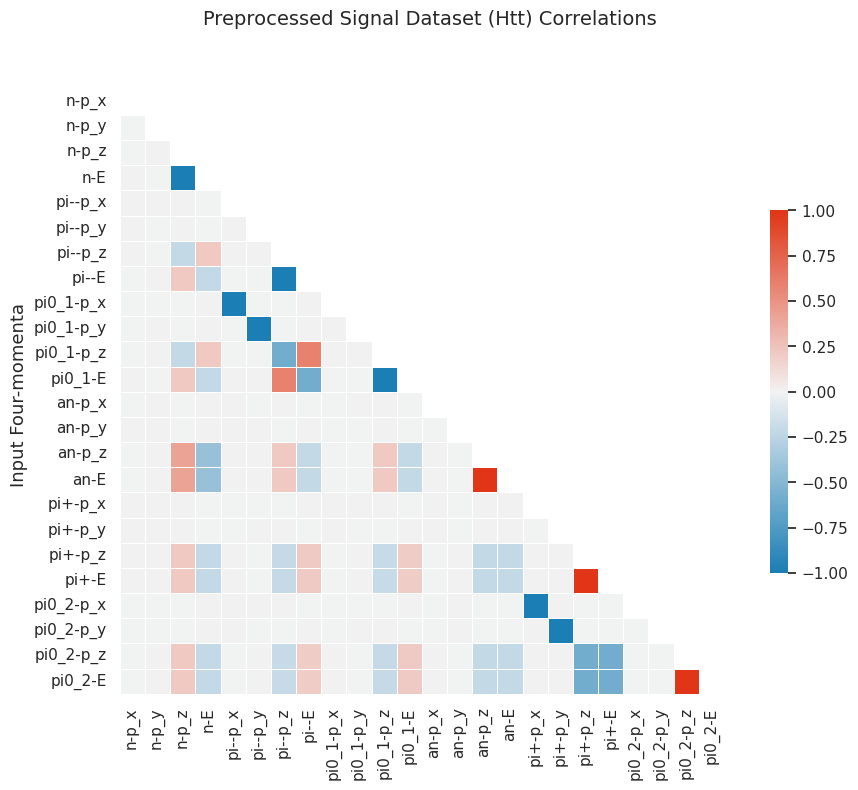

In [70]:
corre_plot(df_rhorho_H_process, figtitle='Preprocessed Signal Dataset (Htt) Correlations', ax_lable= 'Input Four-momenta ')

In [50]:
points_S_B = pickle.load(open(args.IN+'/events_w_background.pk','rb'))
background=[]
background.append(points_S_B.train.x[points_S_B.train.weights.sum(axis=1)==0])
background.append(points_S_B.valid.x[points_S_B.valid.weights.sum(axis=1)==0])
background.append(points_S_B.test.x[points_S_B.test.weights.sum(axis=1)==0])
background=np.concatenate(background)

In [56]:
df_rhorho_Z_process = pd.DataFrame(background)
df_rhorho_Z_process.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
df_rhorho_Z_process

n                                     pi-                      \
             p_x       p_y       p_z         E       p_x       p_y       p_z   
0      -0.029246 -0.217681  1.138138 -1.138485 -0.767399  1.467279  0.186209   
1      -1.105534  0.760022  0.581389 -0.580869 -1.566601 -0.162662  0.558257   
2       1.188350  0.917880 -2.081946  2.081578 -1.121514  1.415153 -0.025489   
3      -0.038359 -1.052267  0.409695 -0.410057  0.319752  0.104365 -2.820214   
4       0.207637  1.075423  0.624430 -0.624406  0.651947  1.681681  0.265484   
...          ...       ...       ...       ...       ...       ...       ...   
999995  1.352666 -1.258502 -0.231840  0.232147  0.107222  0.089965  1.221524   
999996 -0.723329 -1.267842  0.657233 -0.656092  1.161263  0.425932  0.242341   
999997 -0.186002 -1.019867  0.679336 -0.679322 -0.339648  0.806412 -1.083118   
999998 -0.245376 -1.635864  0.053136 -0.052870 -0.457123  1.284030  0.951862   
999999 -0.560946 -1.145850  0.562620 -0.562308 -0.539364  1.147734 -0.518151   

                     pi0_1            ...        an                 pi+  \
               E       p_x       p_y  ...       p_z         E       p_x   
0      -0.186284  0.767399 -1.467279  ...  0.093389  0.093053 -0.219354   
1      -0.558305  1.566601  0.162662  ...  1.167225  1.167403 -1.156215   
2       0.025461  1.121514 -1.415153  ... -1.159215 -1.158805 -0.403827   
3       2.820470 -0.319752 -0.104365  ... -1.150847 -1.151231 -1.406366   
4      -0.265487 -0.651947 -1.681681  ...  0.166337  0.166235 -1.605712   
...          ...       ...       ...  ...       ...       ...       ...   
999995 -1.221916 -0.107222 -0.089965  ... -0.258391 -0.258065  0.852293   
999996 -0.242562 -1.161263 -0.425932  ...  3.057873  3.057707  0.816323   
999997  1.083028  0.339648 -0.806412  ...  0.772161  0.771786  2.013393   
999998 -0.951804  0.457123 -1.284030  ...  0.557357  0.557307 -0.557220   
999999  0.518016  0.539364 -1.147734  ...  1.374774  1.374704 -1.006089   

                                         pi0_2                                
             p_y       p_z         E       p_x       p_y       p_z         E  
0       1.477120 -0.612311 -0.612385  0.219354 -1.477120  1.866117  1.866255  
1       0.243600 -1.038149 -1.038133  1.156215 -0.243600  0.314231  0.314049  
2      -0.941086 -1.123733 -1.123722  0.403827  0.941086  0.660758  0.660604  
3      -0.834872  1.356685  1.356753  1.406366  0.834872  0.175114  0.175033  
4      -1.019633  0.010269  0.010278  1.605712  1.019633 -0.028416 -0.028404  
...          ...       ...       ...       ...       ...       ...       ...  
999995  0.204471  0.449663  0.449451 -0.852293 -0.204471 -0.305808 -0.306131  
999996  0.996383 -0.507976 -0.508169 -0.816323 -0.996383 -0.920211 -0.920242  
999997  0.565552  0.079282  0.079361 -2.013393 -0.565552 -0.246073 -0.245940  
999998  1.599944 -0.769486 -0.769346  0.557220 -1.599944  0.161923  0.161859  
999999 -1.247059 -0.658846 -0.658839  1.006089  1.247059  0.277650  0.277565  

[1000000 rows x 24 columns]

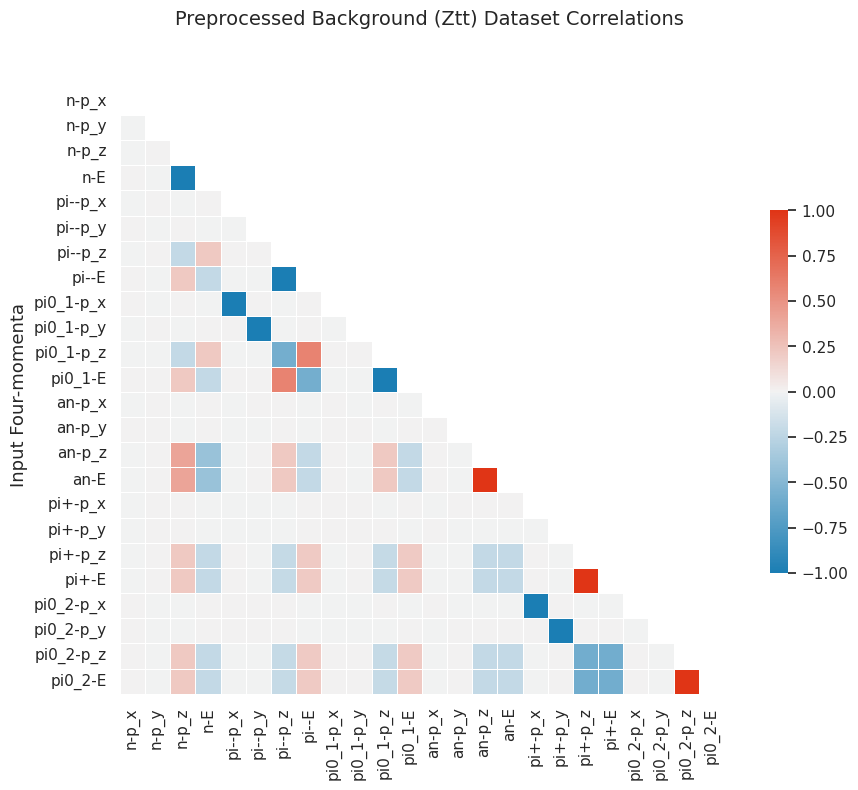

In [71]:
corre_plot(df_rhorho_Z_process, figtitle='Preprocessed Background (Ztt) Dataset Correlations', ax_lable= 'Input Four-momenta ')

In [38]:
df_rhorho_argmax = pd.DataFrame(points_S.train.argmaxs)
df_rhorho_argmax.columns = ['argmaxs']

In [53]:
df_rhorho_argmax

,argmaxs
0,0.021123
1,6.208430
2,5.337085
3,5.445254
4,3.329722
...,...
799995,2.732055
799996,2.144895
799997,0.631563
799998,0.609930


In [47]:
df_rhorho_weights = pd.DataFrame(points_S.train.weights)
df_rhorho_weights.columns = pd.MultiIndex.from_arrays([sum([['weights']*11],[]), df_rhorho_weights.columns])

In [48]:
df_rhorho_weights

weights                                                              \
              0         1         2         3         4         5         6    
0       1.904662  1.735186  1.267922  0.681348  0.199516  0.006469  0.175945   
1       1.957325  1.769308  1.347515  0.853055  0.474796  0.357219  0.545236   
2       1.575939  1.327142  1.078930  0.926111  0.927058  1.081408  1.330205   
3       1.679708  1.197786  0.681843  0.328953  0.273906  0.537729  1.019651   
4       0.762451  0.801704  1.015561  1.322335  1.604849  1.755193  1.715940   
...          ...       ...       ...       ...       ...       ...       ...   
799995  0.240497  0.416388  0.675687  0.919352  1.054311  1.029014  0.853123   
799996  0.118897  0.274000  0.423727  0.510888  0.502190  0.400956  0.245853   
799997  1.889446  1.983401  1.891304  1.648334  1.347297  1.103179  1.009224   
799998  1.051330  1.154290  1.038976  0.749433  0.396257  0.114349  0.011389   
799999  0.591361  0.490252  0.582825  0.833721  1.147107  1.403279  1.504389   

                                                
              7         8         9         10  
0       0.643209  1.229783  1.711615  1.904662  
1       0.967029  1.461489  1.839748  1.957325  
2       1.578417  1.731236  1.730289  1.575939  
3       1.535594  1.888484  1.943531  1.679708  
4       1.502083  1.195309  0.912795  0.762451  
...          ...       ...       ...       ...  
799995  0.593824  0.350159  0.215200  0.240497  
799996  0.096126  0.008965  0.017663  0.118897  
799997  1.101321  1.344291  1.645328  1.889446  
799998  0.126704  0.416247  0.769423  1.051330  
799999  1.411816  1.160919  0.847534  0.591361  

[800000 rows x 11 columns]

In [49]:
df_rhorho_input = pd.concat([df_rhorho_H_process, df_rhorho_weights], axis=1)

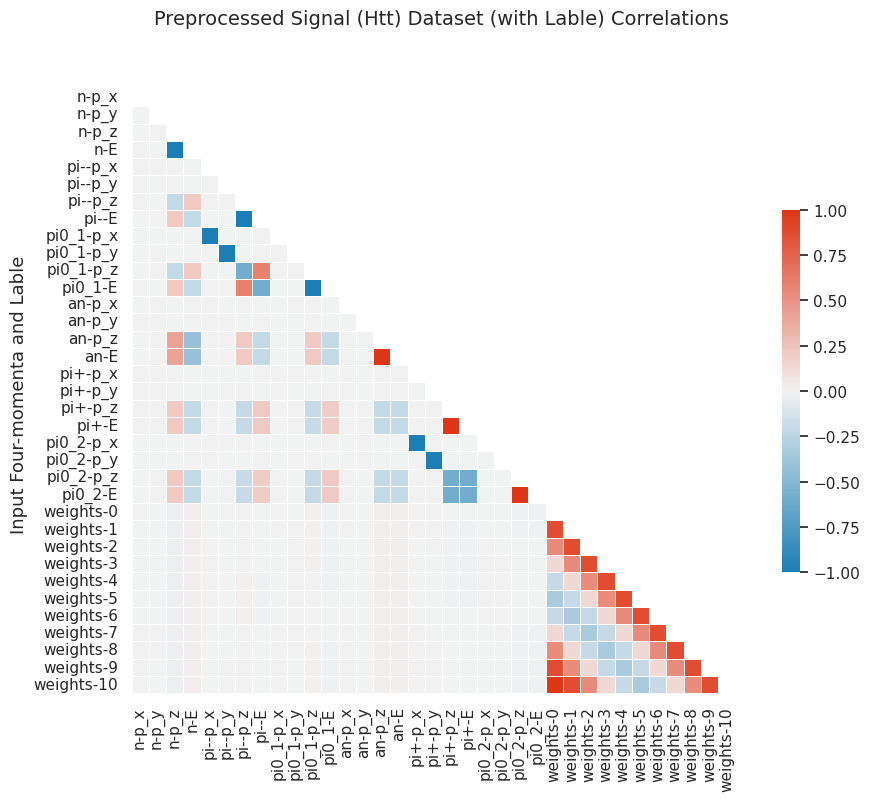

In [50]:
corre_plot(df_rhorho_input, figtitle='Preprocessed Signal (Htt) Dataset (with Lable) Correlations', ax_lable= 'Input Four-momenta and Lable ')

In [89]:
weight_argmaxs = np.argmax(points_S.train.weights, axis=1)

In [90]:
_,counts=np.unique(weight_argmaxs,return_counts=True)

In [91]:
counts

array([80093, 80476, 79909, 79922, 79899, 79551, 80201, 80175, 79612,
       80162])

In [95]:
df_weight_argmaxs = pd.DataFrame(weight_argmaxs)
df_weight_argmaxs

,0
0,0
1,0
2,8
3,9
4,5
...,...
799995,4
799996,3
799997,1
799998,1
